Imports

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
import seaborn as sns


# Pre processing

In [3]:
breast_cancer_df = pd.read_pickle('wdbc.pkl')

In [ ]:
breast_cancer_df.head()

,id,malignant,radius_0,texture_0,perimeter_0,area_0,smoothness_0,compactness_0,concavity_0,concave points_0,...,radius_2,texture_2,perimeter_2,area_2,smoothness_2,compactness_2,concavity_2,concave points_2,symmetry_2,fractal dimension_2
0,842302,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


Split into train and test data

In [4]:
Y = breast_cancer_df[["malignant"]]
X = breast_cancer_df.iloc[:,2:]

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, random_state = 42)

# Rule-based Classifier



The plotting of features in the data set and thereby the choice of threshold was made in features_plot.ipynb


In [8]:
class Rulebased:

  def __init__(self):
    self.scaler = MinMaxScaler()
    self.thresholds = {'Size': 0, 'Shape': 0, 'Texture': 0, 'Homo': 0}

  def fit(self, X_train, Y_train):
    # Normalize data
    self.scaler.fit(X_train)
    X_train = pd.DataFrame(self.scaler.transform(X_train), columns=X_train.columns)

    # Look only at mean values
    #X_train = X_train.iloc[:,0:10]
    merged = pd.concat([X_train.reset_index(drop=True), Y_train.reset_index(drop=True)], axis=1)
    
    condition = merged["malignant"]==1
    malignant = merged[condition]
    benign = merged[~condition]


    # Add column for homogenity
    standard_error = ['radius_1','texture_1','perimeter_1','area_1','smoothness_1','compactness_1','concavity_1','concave points_1','symmetry_1','fractal dimension_1']

    benign['Homo'] = benign[standard_error].mean(axis=1)
    malignant['Homo'] = malignant[standard_error].mean(axis=1)

    keys = list(self.thresholds.keys())
    
    indicators = ['perimeter_0', 'concavity_0', 'texture_0', 'Homo']

    for index, indicator in enumerate(indicators): 

      malignant_sorted = malignant.sort_values(by=indicator, ascending = False)

      # Calculate index at which 5% of malignant cells would be missed (We tolerate 5% false negative)
      num_malignant_cells = len(malignant_sorted)
      num_missed_malignant_cells = int(np.ceil(0.05 * num_malignant_cells))
      threshold_index = num_malignant_cells - num_missed_malignant_cells

      # Set threshold based on radius value at index
      threshold = malignant_sorted.iloc[threshold_index][indicator]

      # Update threshold
      key = keys[index]
      self.thresholds[key] = threshold

  def predict(self, X_test):
    # Normalize data
    X_test = pd.DataFrame(self.scaler.transform(X_test), columns=X_test.columns)

    standard_error = ['radius_1','texture_1','perimeter_1','area_1','smoothness_1','compactness_1','concavity_1','concave points_1','symmetry_1','fractal dimension_1']

    X_test['Homo'] = X_test[standard_error].mean(axis=1)

    pred = []


    #the commented numbers are thresholds we choose from inspection on the plots of 
    #the distibution of the features. These give a much better overall score.
    for index, row in X_test.iterrows():
      if row['perimeter_0'] > self.thresholds['Size']: #0.35
        pred.append(1)
      elif row['concavity_0'] >  self.thresholds['Shape']: #0.31
        pred.append(1)
      elif row['texture_0'] >  self.thresholds['Texture']: #0.75
        pred.append(1)
      elif row['radius_1'] > self.thresholds['Homo']: #0.2
        pred.append(1)
      else:
        pred.append(0)
    
    return pred

  def score(self, Y_test, pred):
    acc = accuracy_score(Y_test, pred)
    prec = precision_score(Y_test, pred)
    recall = recall_score(Y_test, pred)
    f1 = f1_score(Y_test, pred)
    
    print('Accuracy: {:.2f}'.format(acc))
    print('Precision: {:.2f}'.format(prec))
    print('Recall: {:.2f}'.format(recall))
    print('F1 score: {:.2f}'.format(f1))


In [9]:
t = Rulebased()

t.fit(X_train, Y_train)
prediction = t.predict(X_test)
print(prediction)
t.score(Y_test, prediction)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1]
Accuracy: 0.46
Precision: 0.41
Recall: 1.00
F1 score: 0.59


<ipython-input-8-5c1db53cf499>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  benign['Homo'] = benign[standard_error].mean(axis=1)
<ipython-input-8-5c1db53cf499>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  malignant['Homo'] = malignant[standard_error].mean(axis=1)


# Random Forest

Normalize train and test data

<ipython-input-5-3e307da1c124>:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(X_train_norm, Y_train)


MODEL PERFORMANCE:
Accuracy: 0.9649122807017544, 
Precision: 0.975609756097561, 
Recall: 0.9302325581395349, 
F1 Score: 0.9523809523809524
Confusion matrix:


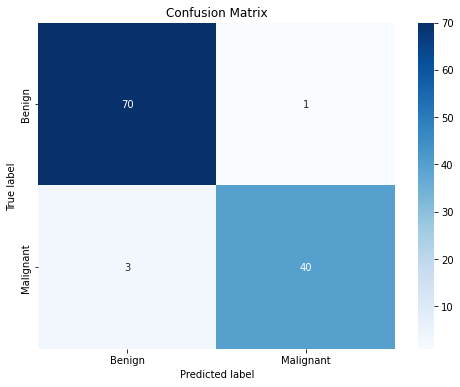

Predicted values:
 [0 1 1 0 0 1 1 1 1 0 0 1 0 1 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1
 0 1 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 1 0 0 1 1 0 0 0 1 1 0 0 1 1 0 1
 0 0 0 0 0 0 1 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 0 1 1 0 1 1 0 0 0 1 0 0 1
 0 0 1]


In [ ]:
def RFC(X_train, Y_train, X_test, Y_test): 

  # Normalize data
  scaler = StandardScaler()
  X_train_norm = scaler.fit_transform(X_train)
  X_test_norm = scaler.transform(X_test)

  # Create an instance of the RandomForestClassifier model and specify hyperparameters
  rfc = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)

  # Train the model on the training data
  rfc.fit(X_train_norm, Y_train)

  # Evaluate the model's performance on the testing data
  Y_pred = rfc.predict(X_test_norm)
  accuracy = accuracy_score(Y_test, Y_pred)
  precision = precision_score(Y_test, Y_pred)
  recall = recall_score(Y_test, Y_pred)
  f1 = f1_score(Y_test, Y_pred)
  print("MODEL PERFORMANCE:")
  print(f"Accuracy: {accuracy}, \nPrecision: {precision}, \nRecall: {recall}, \nF1 Score: {f1}")
  
  conf_mat = confusion_matrix(Y_test, Y_pred)
  print("Confusion matrix:")
  plt.figure(figsize=(8, 6))
  sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt="d", xticklabels=["Benign", "Malignant"], yticklabels=["Benign", "Malignant"])
  plt.xlabel("Predicted label")
  plt.ylabel("True label")
  plt.title("Confusion Matrix")
  plt.show()

  return Y_pred

Y_pred = RFC(X_train, Y_train, X_test, Y_test)
print("Predicted values:\n" ,Y_pred)


**Interpretability of Random Forest**

This model can be quite hard to interpret as it is quite complex comapred to simpler models such as linear regression. This is because a random forest is an ensamble of many desicion trees and the final prediction is made by combining the preictions of each individual tree. This results in the model having many steps that can be hard to follow. 

When just using it in this way to get a list of predictions there is no explantion that comes with the preidtions. This, of course, makes it very hard to inteperet. We can also imagine that a model like this would never be used in a real world setting where the model a doctor work togehter to classify tumors since a doctor would want to know the reasoning behind the diagnosis and not just a binary answer.  

# Our Own Classifier

Identify appropriate max_depth

Text(0.5, 1.0, 'max_depth vs accuracy')

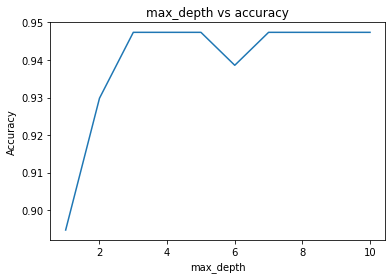

In [ ]:
# Normalize data
scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

# Split the data into training and testing sets
X_train, X_test, _train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


depths = np.linspace(1,10,10)


accuracy = []
for deep in depths:
  # Define the decision tree classifier and fit it to the training data
  clf = DecisionTreeClassifier(max_depth=deep, random_state=42)
  clf.fit(X_train, Y_train)

  # Predict labels for the test set
  Y_pred = clf.predict(X_test)

  # Evaluate the performance of the classifier
  acc = accuracy_score(Y_test, Y_pred)

  accuracy.append(acc)


plt.plot(depths, accuracy)
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.title("max_depth vs accuracy")


No need to have a depth greater than 3

**Adding features to DecisionTreeClassifier to make it more interpretable** 

In [ ]:
def interp_DT(X_train, Y_train, X_test, Y_test): 
  # Normalize data
  scaler = StandardScaler()
  X_train_norm = scaler.fit_transform(X_train)
  X_test_norm = scaler.transform(X_test)

  # Define the decision tree classifier and fit it to the training data
  clf = DecisionTreeClassifier(max_depth=3, random_state=42)
  clf.fit(X_train, Y_train)

  # Predict labels for the test set
  Y_pred = clf.predict(X_test)

  # Evaluate the performance of the classifier
  print("METRICS")
  accuracy = accuracy_score(Y_test, Y_pred)
  precision = precision_score(Y_test, Y_pred)
  recall = recall_score(Y_test, Y_pred)
  f1 = f1_score(Y_test, Y_pred)
  print(f"Accuracy: {accuracy}, \nPrecision: {precision}, \nRecall: {recall}, \nF1 Score: {f1}")
  
  print("________________________________________________________________________________________________________________________________")
  
  conf_mat = confusion_matrix(Y_test, Y_pred)
  print("CONFUSION MATRIX:")
  plt.figure(figsize=(8, 6))
  sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt="d", xticklabels=["Benign", "Malignant"], yticklabels=["Benign", "Malignant"])
  plt.xlabel("Predicted label")
  plt.ylabel("True label")
  plt.title("Confusion Matrix")
  plt.show()

  print("________________________________________________________________________________________________________________________________")
  
  print("REASONING BEHIND CLASSIFICATION")

  # Visualize the decision tree
  print("The decision tree")
  plt.figure(figsize=(20, 12), dpi=200)
  plot_tree(clf, filled=True, feature_names = X.columns, class_names=["Benign", "Malignant"])      
  plt.show()

  # Visualize feature importance 
  print("Feature importance")
  feature_names = X_train.columns
  # Calculate feature importances
  importances = clf.feature_importances_

  # Sort features by importance
  indices = np.argsort(importances)[::-1]

  # Plot feature importances
  plt.figure(figsize=(10, 6))
  plt.title("Feature importances")
  plt.bar(range(X.shape[1]), importances[indices])
  plt.xticks(range(X_train.shape[1]), feature_names[indices], rotation=90)
  plt.show()

  return Y_pred


In [ ]:
test = interp_DT(X_train, Y_train, X_test, Y_test)